In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,f1_score
import xgboost as xgb 
from catboost import CatBoostClassifier

In [2]:
Train = pd.read_csv('Train.csv')
Test = pd.read_csv('Test.csv') 
submission = pd.read_csv('SampleSubmission.csv') 

In [3]:
print(f'Train size {Train.shape}, Test size {Test.shape}')
Train.head()

Train size (1568, 27), Test size (672, 26)


,ID,Year_of_Birth,Education_Level,Marital_Status,Disposable_Income,No_of_Kids_in_home,No_of_Teen_in_home,Date_Customer,Recency,Discounted_Purchases,...,Amount_on_SweetProducts,Amount_on_GoldProds,WebVisitsMonth,Cmp3Accepted,Cmp4Accepted,Cmp5Accepted,Cmp1Accepted,Cmp2Accepted,Any_Complain,Response
0,ID_4A9AR6FQ,1955,Graduation,Divorced,77504.4,1,1,22-06-2014,56,2,...,6,20,3,0,0,0,0,0,0,0
1,ID_X28T3VEK,1958,Graduation,Together,56784.0,0,1,01-08-2013,17,6,...,15,19,6,0,0,0,0,0,0,0
2,ID_AWXARH57,1962,Graduation,Single,103714.8,0,0,21-11-2013,17,0,...,18,37,2,0,0,0,1,0,0,1
3,ID_FQVZHE81,1979,2n Cycle,Single,46311.6,1,0,13-09-2013,49,3,...,24,24,8,0,0,0,0,0,0,0
4,ID_QVLWGPRN,1959,Graduation,Married,87486.0,0,0,21-01-2014,59,1,...,165,203,1,0,0,0,1,0,0,0


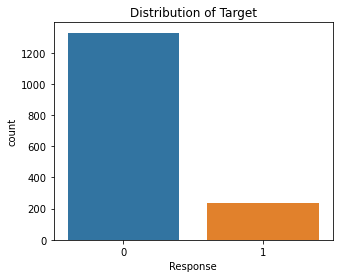

In [4]:
f, ax = plt.subplots(figsize=(5, 4))
ax = sns.countplot(x="Response", data=Train)
plt.title(f'Distribution of Target')
plt.show()

In [5]:
Train['Marital_Status'].value_counts()#'Education_Level', 'Marital_Status'

Married     615
Together    409
Single      329
Divorced    159
Widow        50
Alone         3
YOLO          2
Absurd        1
Name: Marital_Status, dtype: int64

In [6]:
Test['Marital_Status'].value_counts()

Married     249
Together    171
Single      151
Divorced     73
Widow        27
Absurd        1
Name: Marital_Status, dtype: int64

In [7]:
for i in ['Absurd','YOLO']:
    Train.loc[Train['Marital_Status'] == i,['Marital_Status']] ='others'
    Test.loc[Test['Marital_Status'] == i,['Marital_Status']] ='others'

In [8]:
ntrain = Train.shape[0]
ntest = Test.shape[0]
all_data = pd.concat((Train, Test)).reset_index(drop=True)
all_data['Date_Customer'] = pd.to_datetime(all_data['Date_Customer'])
all_data['date_year'] = all_data['Date_Customer'].dt.year
all_data['date_quart']=all_data['Date_Customer'].dt.quarter
all_data['date_month'] = all_data['Date_Customer'].dt.month
all_data['rwp']= all_data['Recency']/all_data['WebVisitsMonth']
all_data['cata'] =all_data['Amount_on_MeatProducts']/all_data['CatalogPurchases']
all_data['yearly_expenses'] = (all_data[['Amount_on_Fruits', 'Amount_on_MeatProducts', 'Amount_on_FishProducts',
       'Amount_on_SweetProducts', 'Amount_on_GoldProds']].sum(axis=1))/3
all_data['spending_ration'] = all_data['Disposable_Income']/all_data['yearly_expenses']

In [9]:
all_data = pd.get_dummies(all_data,columns=['Education_Level', 'Marital_Status'],drop_first=True)


In [10]:
drop = ["ID",'Date_Customer']
all_data.drop(drop, axis=1, inplace = True)
test = all_data[ntrain:].copy()
train = all_data[:ntrain].copy()
target = train.Response.copy()

In [11]:
value = train['Disposable_Income'].median()
train['Disposable_Income'].fillna(value,inplace=True)
test['Disposable_Income'].fillna(value,inplace= True)

In [12]:
train.drop(['Response'] ,axis=1, inplace=True)

test.drop(['Response'], axis=1, inplace=True)
test = test.reset_index(drop=True)
train.columns

Index(['Year_of_Birth', 'Disposable_Income', 'No_of_Kids_in_home',
       'No_of_Teen_in_home', 'Recency', 'Discounted_Purchases', 'WebPurchases',
       'CatalogPurchases', 'StorePurchases', 'Amount_on_Wines',
       'Amount_on_Fruits', 'Amount_on_MeatProducts', 'Amount_on_FishProducts',
       'Amount_on_SweetProducts', 'Amount_on_GoldProds', 'WebVisitsMonth',
       'Cmp3Accepted', 'Cmp4Accepted', 'Cmp5Accepted', 'Cmp1Accepted',
       'Cmp2Accepted', 'Any_Complain', 'date_year', 'date_quart', 'date_month',
       'rwp', 'cata', 'yearly_expenses', 'spending_ration',
       'Education_Level_Basic', 'Education_Level_Graduation',
       'Education_Level_Master', 'Education_Level_PhD',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_others'],
      dtype='object')

In [13]:
np.bincount(target)[0],np.bincount(target)[1]

(1329, 239)

In [14]:
from math import sqrt
weight = np.bincount(target)[0]/np.bincount(target)[1]
estimator = xgb.XGBClassifier(scale_pos_weight=weight,n_jobs=-1,max_depth= 4,random_state=64,
                          sub_sample = 0.8, n_estimators = 500,gamma=1,min_child_weight=10,
                          colsample_bytree =0.8 )
skfolds = StratifiedKFold(n_splits = 10,shuffle=True,random_state=52)

In [15]:
mean_train,mean_test_val = [],[]
test_pred = np.zeros(test.shape[0])
val_pred = np.zeros(train.shape[0])
for count, (train_index,test_index) in enumerate(skfolds.split(train,target)):
    x_train,x_test = train.iloc[train_index],train.iloc[test_index]
    y_train,y_test = target.iloc[train_index],target.iloc[test_index]
    print(f'========================Fold{count +1}==========================')
    estimator.fit(x_train, y_train, early_stopping_rounds = 200, eval_metric="auc",
                       eval_set=[(x_test, y_test)],verbose=250)
    train_predict = estimator.predict_proba(x_train)[:,1]
    test_predict = estimator.predict_proba(x_test)[:,1]
    val_pred[test_index] = test_predict
    test_pred+= estimator.predict_proba(test)[:,1]

    print('\nTesting scores', roc_auc_score(y_test,test_predict))
    print('\nTraining scores', roc_auc_score(y_train,train_predict))
    mean_train.append(roc_auc_score(y_train, train_predict))
    mean_test_val.append(roc_auc_score(y_test,test_predict))
test_pred = test_pred/10
print('Average Testing ROC score for 10 folds split:',np.mean(mean_test_val))
print('Average Training ROC score for 10 folds split:',np.mean(mean_train))
print('standard Deviation for 10 folds split:',np.std(mean_test_val))
# Average Testing ROC score for 7 folds split: 0.9020010706938624
# Average Training ROC score for 7 folds split: 0.9943098099481806
# standard Deviation for 7 folds split: 0.033282697319695895

========================Fold1==========================


/home/alli/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoostError: [09:40:32] ../src/data/data.cc:945: Check failed: valid: Input data contains `inf` or `nan`
Stack trace:
  [bt] (0) /home/alli/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9133f) [0x7fa34d24f33f]
  [bt] (1) /home/alli/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x14e930) [0x7fa34d30c930]
  [bt] (2) /home/alli/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x15f8ff) [0x7fa34d31d8ff]
  [bt] (3) /home/alli/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x156cf5) [0x7fa34d314cf5]
  [bt] (4) /home/alli/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGDMatrixCreateFromMat_omp+0x7c) [0x7fa34d24704c]
  [bt] (5) /home/alli/anaconda3/lib/python3.8/lib-dynload/../../libffi.so.7(+0x69dd) [0x7fa434d0c9dd]
  [bt] (6) /home/alli/anaconda3/lib/python3.8/lib-dynload/../../libffi.so.7(+0x6067) [0x7fa434d0c067]
  [bt] (7) /home/alli/anaconda3/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x8f3) [0x7fa434d26d03]
  [bt] (8) /home/alli/anaconda3/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x15064) [0x7fa434d27064]



In [18]:
print(xgb.__version__) 

1.4.2


In [ ]:
pd.Series(test_pred).describe()

count    672.000000
mean       0.221226
std        0.256003
min        0.016745
25%        0.038254
50%        0.093721
75%        0.312862
max        0.972651
dtype: float64

In [ ]:
threshold= 0.45
predictions = [1  if prediction > threshold else 0 for prediction in test_pred]

In [ ]:
submission['Response'] = predictions

submission.to_csv("pred_22.csv",index=False)

##DO NOT SUBMIT THIS ITS FOR THE WEIGHTGED AVERAGE EXAMPLE
submission['Response'] = test_pred

submission.to_csv("to_be_weighted_xgb.csv",index=False)

In [ ]:
g = pd.read_csv("pred_22.csv")
print(g['Response'].value_counts())

0    547
1    125
Name: Response, dtype: int64


**LB: 0.681818181818182**